# Jigsaw unintended bias in toxicity classification

In [1]:

import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

from sklearn import metrics

import time
import pickle 

import pandas as pd

In [2]:
os.listdir("../")

['classical Models', 'Deep Models', 'input']

## Loding Data in dataframe

In [3]:


# Import the test and train datasets into pandas dataframe
#train = pd.read_csv('../content/train.csv.zip', compression='zip', header=0, sep=',', quotechar='"')

train = pd.read_csv('../input/train.csv')
submission_TFIDF = pd.read_csv('../input/test.csv')

## 1. EDA on Train Data

In [4]:
#print("Number of Datapoints in Train:{}\nNumber of Datapoints in Test:{}".format(train.shape,test.shape))
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [5]:
# Printing the info of all the colums in our training dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 45 columns):
id                                     int64
target                                 float64
comment_text                           object
severe_toxicity                        float64
obscene                                float64
identity_attack                        float64
insult                                 float64
threat                                 float64
asian                                  float64
atheist                                float64
bisexual                               float64
black                                  float64
buddhist                               float64
christian                              float64
female                                 float64
heterosexual                           float64
hindu                                  float64
homosexual_gay_or_lesbian              float64
intellectual_or_learning_disability    float

<h3> Distribution of data points among Target classes</h3>
- Number of Toxic and non-Toxic comments

In [6]:
Data_EDA=pd.DataFrame({'target':(train['target'].values>=0.5).astype(bool).astype(np.int)})
Data_EDA["Labels"]=Data_EDA['target'].apply(lambda x:"Non Toxic" if x==0 else "Toxic" )
Data_EDA["comment_length"]=train['comment_text'].str.len()
Data_EDA["comment_text"]=train['comment_text']

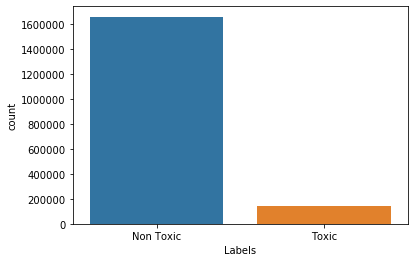

In [7]:
sns.countplot(Data_EDA["Labels"])
#sns.countplot((train['target'].values<0.5).astype(bool).astype(np.int),label=["Toxic","Non Toxic"])

In [8]:
print(len(train.comment_text[train['target'] >= 0.5]) /      len(train['comment_text']) * 100,'percent of toxic')
print(len(train.comment_text[train['target'] < 0.5]) / len(train['comment_text']) * 100,'percent of non toxic')

7.99690172277954 percent of toxic
92.00309827722046 percent of non toxic


In [9]:
unique_qs = len(np.unique(train['comment_text']))
qs_morethan_onetime = np.sum(train['comment_text'].value_counts() > 1)

In [10]:
unique_qs

1780823

In [11]:
qs_morethan_onetime

10180

<h3>Checking for Duplicates in Train Data</h3>

In [12]:
train.duplicated(subset=set(train.columns)).value_counts()

False    1804874
dtype: int64

#### So there is no duplicate rows in train data

<h3>Checking for NULL values </h3>

In [13]:
train.isnull().sum()

id                                           0
target                                       0
comment_text                                 0
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male         

### Plotting box Plots for Non Toxic and Toxic comments based on their lengths

In [14]:
Data_EDA=pd.DataFrame({'target':(train['target'].values>=0.5).astype(bool).astype(np.int)})
Data_EDA["Labels"]=Data_EDA['target'].apply(lambda x:"Non Toxic" if x==0 else "Toxic" )
Data_EDA["comment_length"]=train['comment_text'].str.len()
Data_EDA["comment_text"]=train['comment_text']

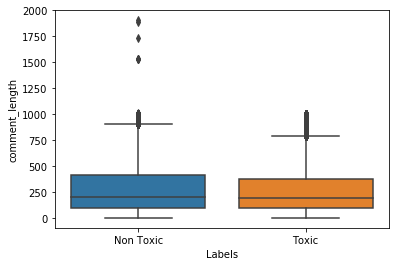

In [15]:
ax = sns.boxplot(x="Labels", y="comment_length", data=Data_EDA)

In [16]:
#looking for the percecntile values
for i in range(0,100,10):
    var =Data_EDA[Data_EDA["Labels"]=="Toxic"]["comment_length"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is 3
10 percentile value is 52
20 percentile value is 83
30 percentile value is 115
40 percentile value is 151
50 percentile value is 195
60 percentile value is 250
70 percentile value is 324
80 percentile value is 436
90 percentile value is 652
100 percentile value is  1000


In [17]:
#looking for the percecntile values
for i in range(0,100,10):
    var =Data_EDA[Data_EDA["Labels"]=="Non Toxic"]["comment_length"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is 1
10 percentile value is 47
20 percentile value is 77
30 percentile value is 111
40 percentile value is 152
50 percentile value is 203
60 percentile value is 269
70 percentile value is 358
80 percentile value is 496
90 percentile value is 755
100 percentile value is  1906


### Let's print the comments have len more than 1300 

In [18]:
Data_EDA_len=Data_EDA[Data_EDA["comment_length"]>1300]

In [19]:
Data_EDA_len

,target,Labels,comment_length,comment_text
169,0,Non Toxic,1737,"Am I missing something, because there's nothin..."
248,0,Non Toxic,1906,"Predatory patrol towing isn't a big subject, a..."
401,0,Non Toxic,1535,"I'm not a big fan of either, but I've seen bot..."
1894,0,Non Toxic,1891,As usual WW plumbing the depths for deeper mea...
33197,0,Non Toxic,1535,"I'm not a big fan of either, but I've seen bot..."
88955,0,Non Toxic,1535,"I'm not a big fan of either, but I've seen bot..."
115884,0,Non Toxic,1535,"I'm not a big fan of either, but I've seen bot..."


### So we observe Sizes of Non Toxic comments is large

<h2> Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____total_length____ = length of comment
 - ____capitals____ = number of capitals in comment 
 - ____caps_vs_length____ = (number of capitals in comment)
 - ____num_exclamation_marks____ = num exclamation marks
 - ____num_question_marks____ = num question marks
 - ____num_punctuation____ = Number of num punctuation
 - ____num_symbols____ = Number of symbols (@, #, $, %, ^, &, *, ~)
 - ____num_words____ = Total numer of words
 - ____num_unique_words____ = Number unique words
 - ____words_vs_unique____ = number of unique words/number of words
 - ____num_smilies____ = number of smilies
 - ____word_density____ = taking average of each word density within the comment
 - ____num_stopWords____ = number of Stopwords in comment
 - ____num_nonStopWords____ = number of non Stopwords in comment
 - ____num_nonStopWords_density____ = (num stop words)/(num stop words + num non stop words)
 - ____num_stopWords_density____ = (num non stop words)/(num stop words + num non stop words)

In [20]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import nltk
nltk.download('stopwords')  
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anurag\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
def wordDensity(text):
    text=re.sub('[.,!?;:()*&^%$#@_+\~\'"]', '', text)
    words=text.split()
    uniqueWords=set(words)
    density=[]
    if len(words)==0:
        return 0   
    for i in uniqueWords:       
        density.append(words.count(i)/len(words))   
    return sum(density)/len(density)    

In [22]:
def numerical_features(df): 
    df['total_length'] = df['comment_text'].apply(len)
    df['capitals'] = df['comment_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['total_length']),axis=1)
    df['num_exclamation_marks'] = df['comment_text'].apply(lambda comment: comment.count('!'))
    df['num_question_marks'] = df['comment_text'].apply(lambda comment: comment.count('?'))
    df['num_punctuation'] = df['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '.,;:'))
    df['num_symbols'] = df['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '@^$*&$%`#'))
    df['num_words'] = df['comment_text'].apply(lambda comment: len(comment.split()))
    df['num_unique_words'] = df['comment_text'].apply(lambda comment: len(set(w for w in comment.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['num_words']
    df['num_smilies'] = df['comment_text'].apply(lambda comment: sum(comment.count(w) for w in (':-)', ':)', ';-)', ';)')))
    df['word_density'] = df['comment_text'].apply(wordDensity)
    df['num_stopWords']=df['comment_text'].apply(lambda comment: sum(1 for c in comment if c in stop_words))
    df['num_nonStopWords']=df['comment_text'].apply(lambda comment: sum(1 for c in comment if c not in stop_words))
    df['num_nonStopWords_density']=df.apply(lambda row: float(row['num_nonStopWords'])/(float(row['num_stopWords'])+float(row['num_nonStopWords'])),axis=1)
    df['num_stopWords_density']=df.apply(lambda row: float(row['num_stopWords'])/(float(row['num_stopWords'])+float(row['num_nonStopWords'])),axis=1)
    
    return df

In [23]:
train["Labels"]=Data_EDA["Labels"]

In [24]:
train=numerical_features(train)

In [25]:
submission_TFIDF = numerical_features(submission_TFIDF)

In [26]:
submission_TFIDF.head()

,id,comment_text,total_length,capitals,caps_vs_length,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,num_words,num_unique_words,words_vs_unique,num_smilies,word_density,num_stopWords,num_nonStopWords,num_nonStopWords_density,num_stopWords_density
0,7097320,[ Integrity means that you pay your debts.]\n\...,84,4,0.047619,0,1,1,0,15,15,1.000000,0,0.066667,36,48,0.571429,0.428571
1,7097321,This is malfeasance by the Administrator and t...,84,4,0.047619,1,0,1,0,14,13,0.928571,0,0.076923,36,48,0.571429,0.428571
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...,198,8,0.040404,0,0,5,1,35,31,0.885714,0,0.032258,59,139,0.702020,0.297980
3,7097323,"Paul: Thank you for your kind words. I do, in...",993,31,0.031219,0,0,37,0,162,114,0.703704,0,0.009804,358,635,0.639476,0.360524
4,7097324,Sorry you missed high school. Eisenhower sent ...,345,18,0.052174,0,0,3,2,65,51,0.784615,0,0.020000,122,223,0.646377,0.353623


In [27]:
train['num_stopWords_density']

0          0.376238
1          0.359649
2          0.372093
3          0.357143
4          0.333333
             ...   
1804869    0.345178
1804870    0.324324
1804871    0.333333
1804872    0.345404
1804873    0.365217
Name: num_stopWords_density, Length: 1804874, dtype: float64

In [28]:
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,num_symbols,num_words,num_unique_words,words_vs_unique,num_smilies,word_density,num_stopWords,num_nonStopWords,num_nonStopWords_density,num_stopWords_density
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,0,19,19,1.000000,0,0.052632,38,63,0.623762,0.376238
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,0,22,22,1.000000,0,0.045455,41,73,0.640351,0.359649
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,0,16,16,1.000000,0,0.062500,32,54,0.627907,0.372093
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,0,17,16,0.941176,0,0.062500,30,54,0.642857,0.357143
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,0,8,8,1.000000,0,0.125000,12,24,0.666667,0.333333


## Analysis of the extracted features 

### Here we are going to check correlations of Extracted features with Target and subgroups (Identities)



In [29]:
#https://www.kaggle.com/nz0722/simple-eda-text-preprocessing-jigsaw


features = ('total_length', 'capitals', 'caps_vs_length', 'num_exclamation_marks','num_question_marks', 'num_punctuation', 'num_words', 'num_unique_words','words_vs_unique',\
            'num_smilies', 'num_symbols','word_density','num_stopWords','num_nonStopWords','num_nonStopWords_density','num_stopWords_density')
columns = ('target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'funny', 'wow', 'sad', 'likes', 'disagree', 'sexual_explicit','identity_annotator_count', 'toxicity_annotator_count')
rows = [{c:train[f].corr(train[c]) for c in columns} for f in features]
train_correlations = pd.DataFrame(rows, index=features)

In [30]:
train_correlations

,target,severe_toxicity,obscene,identity_attack,insult,threat,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
total_length,0.006444,0.007962,0.009823,0.053430,0.009085,-0.013198,-0.084710,0.002572,-0.019940,0.060639,0.017617,0.019882,0.020840,-0.030894
capitals,0.026120,0.025127,0.027995,0.050489,0.026358,0.000721,-0.039221,0.009687,-0.005448,0.018707,0.003928,0.014144,0.012405,-0.009082
caps_vs_length,-0.005344,0.010594,0.017088,-0.008477,-0.006029,0.000822,0.021263,-0.000603,0.002848,-0.038470,-0.021716,-0.003575,-0.005510,0.015381
num_exclamation_marks,0.055152,0.035388,0.056108,0.017085,0.052533,0.021267,0.007073,0.002225,0.005158,-0.007866,-0.009384,0.019437,0.000869,0.024115
num_question_marks,0.019308,0.011662,0.019233,0.028554,0.014366,-0.000430,-0.009290,0.001263,0.002023,-0.002731,-0.002180,0.015987,0.006305,-0.003307
num_punctuation,0.016974,0.013266,0.017701,0.042990,0.018911,-0.006479,-0.057187,0.001959,-0.016511,0.029581,0.001415,0.018985,0.018050,-0.021231
num_words,0.009579,0.009696,0.014536,0.050527,0.011975,-0.009893,-0.084398,0.002714,-0.019412,0.059481,0.016121,0.021525,0.020595,-0.029856
num_unique_words,0.016702,0.011900,0.017918,0.053659,0.019494,-0.008946,-0.085764,0.003490,-0.018110,0.063874,0.019634,0.022816,0.020787,-0.029814
words_vs_unique,0.001172,-0.005329,-0.003007,-0.048941,0.001135,0.009367,0.079045,-0.004150,0.016223,-0.060162,-0.020712,-0.015748,-0.019749,0.027853
num_smilies,-0.010040,-0.003877,-0.001024,-0.008337,-0.009401,-0.003190,0.010109,-0.002777,-0.002133,-0.016607,-0.010936,-0.000414,-0.000576,-0.003030


### Plotting the correlation values using seaborn heatmap

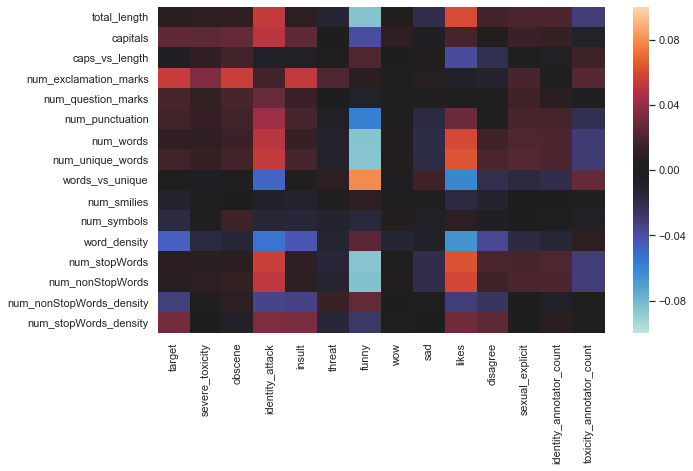

In [31]:
plt.figure(figsize=(10, 6))
sns.set(font_scale=1)
ax = sns.heatmap(train_correlations, vmin=-0.1, vmax=0.1, center=0.0)

## In this section, we are going to apply various feature selection methods and choose the results of the optimum one.

* ### We are refrering feature selection methods from <a href="https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b" target="_blank"><b>this</b></a> blog.

## 1. Filter Method:

### In this method we filter and select only subset of the revelent features, and filtering is done via correlation matrix which implements Pearson correlation. We will only select features which has correlation of above 0.5 (taking absolute value) with the output variable.


### The correlation coefficient has values between -1 to 1
* A value closer to 0 implies weaker correlation (exact 0 implying no correlation)
* A value closer to 1 implies stronger positive correlation
* A value closer to -1 implies stronger negative correlation


In [32]:
corr = train[['total_length', 'capitals', 'caps_vs_length', 'num_exclamation_marks','num_question_marks', 'num_punctuation', 'num_words', 'num_unique_words','words_vs_unique',\
            'num_smilies', 'num_symbols','word_density','num_stopWords','num_nonStopWords','num_nonStopWords_density','num_stopWords_density','target']].corr()

In [33]:
corr

,total_length,capitals,caps_vs_length,num_exclamation_marks,num_question_marks,num_punctuation,num_words,num_unique_words,words_vs_unique,num_smilies,num_symbols,word_density,num_stopWords,num_nonStopWords,num_nonStopWords_density,num_stopWords_density,target
total_length,1.000000,0.578663,-0.173319,0.052521,0.188509,0.783731,0.992389,0.987286,-0.811258,-0.000133,0.162262,-0.394037,0.994597,0.998256,-0.094256,0.094256,0.006444
capitals,0.578663,1.000000,0.295015,0.164878,0.166013,0.512230,0.571097,0.572629,-0.449970,0.004636,0.141576,-0.224310,0.532081,0.602367,0.150434,-0.150434,0.026120
caps_vs_length,-0.173319,0.295015,1.000000,0.115435,-0.000974,-0.102382,-0.174606,-0.186526,0.183269,0.004092,-0.003830,0.383724,-0.197959,-0.158472,0.486644,-0.486644,-0.005344
num_exclamation_marks,0.052521,0.164878,0.115435,1.000000,0.063034,0.034596,0.053694,0.056221,-0.029203,0.014303,0.027985,0.003334,0.038275,0.060369,0.106028,-0.106028,0.055152
num_question_marks,0.188509,0.166013,-0.000974,0.063034,1.000000,0.114151,0.189971,0.194765,-0.139519,0.000478,0.039742,-0.088136,0.179960,0.192462,0.023581,-0.023581,0.019308
num_punctuation,0.783731,0.512230,-0.102382,0.034596,0.114151,1.000000,0.767464,0.772271,-0.598087,0.025851,0.158639,-0.302525,0.763015,0.791736,0.022982,-0.022982,0.016974
num_words,0.992389,0.571097,-0.174606,0.053694,0.189971,0.767464,1.000000,0.991576,-0.827632,0.001571,0.156851,-0.401638,0.986358,0.991039,-0.092084,0.092084,0.009579
num_unique_words,0.987286,0.572629,-0.186526,0.056221,0.194765,0.772271,0.991576,1.000000,-0.794940,0.002711,0.156331,-0.434760,0.980516,0.986381,-0.096260,0.096260,0.016702
words_vs_unique,-0.811258,-0.449970,0.183269,-0.029203,-0.139519,-0.598087,-0.827632,-0.794940,1.000000,0.007627,-0.121308,0.398746,-0.809154,-0.808547,0.099340,-0.099340,0.001172
num_smilies,-0.000133,0.004636,0.004092,0.014303,0.000478,0.025851,0.001571,0.002711,0.007627,1.000000,0.005825,0.002066,-0.002654,0.001302,0.032618,-0.032618,-0.010040


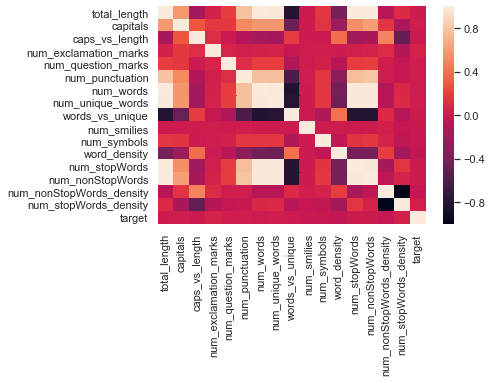

In [34]:
sns.heatmap(corr)

In [35]:
#Correlation with output variable

cor_target = abs(corr["target"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

target    1.0
Name: target, dtype: float64

### So using this method we are not getting any feature as we are getting very less correlation values for all features

## 2. Wrapper Method:

This method uses one machine learning algorithm and uses its performance as evaluation criteria. So we have to feed the features to the selected Machine Learning algorithm and based on the model performance we will add/remove the features. This is an iterative and computationally expensive process but it is more accurate than the filter method.
There are different wrapper methods such as Backward Elimination, Forward Selection, Bidirectional Elimination and RFE. 

### a. Backward Elimination


we feed all the possible features to the model at first. We check the performance of the model and then iteratively remove the worst performing features one by one till the overall performance of the model comes in acceptable range.
The performance metric used here to evaluate feature performance is pvalue. If the pvalue is above 0.05 then we remove the feature, else we keep it.

In [36]:
#Adding constant column of ones, mandatory for sm.OLS model
import statsmodels.api as sm

extracted_features = train[['total_length', 'capitals', 'caps_vs_length', 'num_exclamation_marks','num_question_marks', 'num_punctuation', 'num_words', 'num_unique_words','words_vs_unique',\
            'num_smilies', 'num_symbols','word_density','num_stopWords','num_nonStopWords','num_nonStopWords_density','num_stopWords_density']]

X_1 = sm.add_constant(extracted_features)
#Fitting sm.OLS model
model = sm.OLS(train["target"],X_1).fit()
model.pvalues

C:\Users\Anurag\Anaconda3\envs\New TensorFlow\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


const                        5.293509e-01
total_length                 5.294312e-01
capitals                    3.098820e-187
caps_vs_length               2.254863e-24
num_exclamation_marks        0.000000e+00
num_question_marks           3.585784e-81
num_punctuation             1.256974e-306
num_words                    3.633147e-05
num_unique_words             0.000000e+00
words_vs_unique              3.796957e-14
num_smilies                  5.388238e-54
num_symbols                  5.915443e-97
word_density                3.515001e-285
num_stopWords                5.294312e-01
num_nonStopWords             5.294312e-01
num_nonStopWords_density     5.293810e-01
num_stopWords_density        5.295619e-01
dtype: float64

## Using above code snippet we can see pvalues of respective features, we are applying OLS model which stands for “Ordinary Least Squares”. This model is used for performing linear regression. 


In [37]:
#Backward Elimination
cols = list(extracted_features.columns)
y=train["target"]
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = extracted_features[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    print(feature_with_p_max)
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)
print(len(selected_features_BE))

num_stopWords_density
num_nonStopWords
num_words
['total_length', 'capitals', 'caps_vs_length', 'num_exclamation_marks', 'num_question_marks', 'num_punctuation', 'num_words', 'num_unique_words', 'words_vs_unique', 'num_smilies', 'num_symbols', 'word_density', 'num_stopWords', 'num_nonStopWords_density']
14


### So we selected 14 features from 16
This method following feates as unimportant features:
1. num_stopWords_density
2. num_nonStopWords    


### b. RFE (Recursive Feature Elimination)

The Recursive Feature Elimination (RFE) method works by recursively removing attributes and building a model on those attributes that remain. It uses accuracy metric to rank the feature according to their importance. The RFE method takes the model to be used and the number of required features as input. It then gives the ranking of all the variables, 1 being most important. It also gives its support, True being relevant feature and False being irrelevant feature.

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

y=train["target"]
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 7)
#Transforming data using RFE
X_rfe = rfe.fit_transform(extracted_features,y)  
#Fitting the data to model
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)

[ True False  True False False False False False False False False  True
  True  True  True  True]
[ 1  9  1  4  5  8 10  7  2  3  6  1  1  1  1  1]


### Here we took LinearRegression model with 16 features and RFE gave feature ranking as above. Now we need to find the optimum number of features, for which the accuracy is the highest. We do that by using loop starting with 1 feature and going up to 16. We then take the one for which the accuracy is highest.

In [39]:
#no of features
nof_list=np.arange(1,16)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(extracted_features,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))


Optimum number of features: 15
Score with 15 features: 0.011768


### As seen from above code, the optimum number of features is 15. We now feed 15 as number of features to RFE and get the final set of features given by RFE method, as follows:

In [40]:
cols = list(extracted_features.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 15)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(extracted_features,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['total_length', 'capitals', 'caps_vs_length', 'num_exclamation_marks',
       'num_question_marks', 'num_punctuation', 'num_unique_words',
       'words_vs_unique', 'num_smilies', 'num_symbols', 'word_density',
       'num_stopWords', 'num_nonStopWords', 'num_nonStopWords_density',
       'num_stopWords_density'],
      dtype='object')


In [41]:
set(extracted_features.columns)-set(selected_features_rfe)

{'num_words'}

## So this model is marking 'num_words' as unimportant feature

## 3. Embedded Method
Embedded methods are iterative in a sense that takes care of each iteration of the model training process and carefully extract those features which contribute the most to the training for a particular iteration. Regularization methods are the most commonly used embedded methods which penalize a feature given a coefficient threshold.
Here we will do feature selection using Lasso regularization. If the feature is irrelevant, lasso penalizes it’s coefficient and make it 0. Hence the features with coefficient = 0 are removed and the rest are taken.

In [42]:
reg = LassoCV()
reg.fit(extracted_features, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(extracted_features,y))
coef = pd.Series(reg.coef_, index = extracted_features.columns)

C:\Users\Anurag\Anaconda3\envs\New TensorFlow\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Anurag\Anaconda3\envs\New TensorFlow\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1144.7697808608646, tolerance: 7.009919024446631
  positive)


Best alpha using built-in LassoCV: 0.000342
Best score using built-in LassoCV: 0.010410


Text(0.5, 1.0, 'Feature importance using Lasso Model')

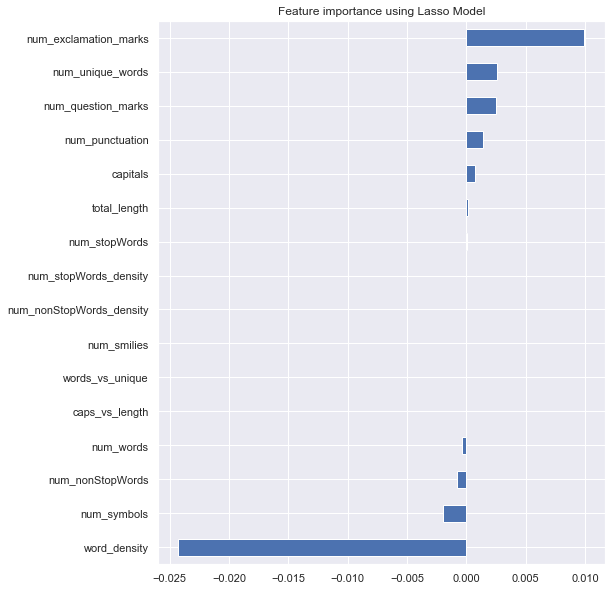

In [43]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

## This method mark following features as unimportant

1. caps_vs_length              
2. words_vs_unique             
3. num_smilies                 
4. num_nonStopWords_density    
5. num_stopWords_density       

## After perfermoning all the methods of feature selection we are going to select results of Embedded Method and will include selected features in our trainning 

## Dropping the unimportant features 

In [44]:
train=train.drop(['caps_vs_length', 'words_vs_unique','num_smilies','num_nonStopWords_density','num_stopWords_density'], axis=1)

## Plotting Vilion and Density plot for some of the extracted features with target labels

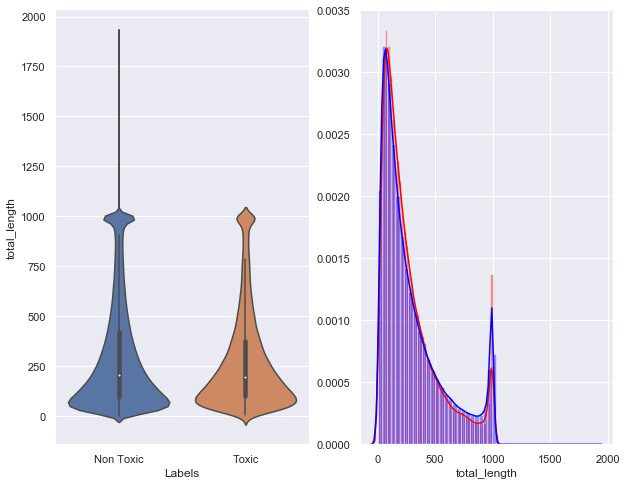

In [45]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'Labels', y = 'total_length', data = train[0:] , )

plt.subplot(1,2,2)
sns.distplot(train[train['Labels'] == "Toxic"]['total_length'][0:] , label = "Toxic", color = 'red')
sns.distplot(train[train['Labels'] == "Non Toxic"]['total_length'][0:] , label = "Non Toxic" , color = 'blue' )
plt.show()

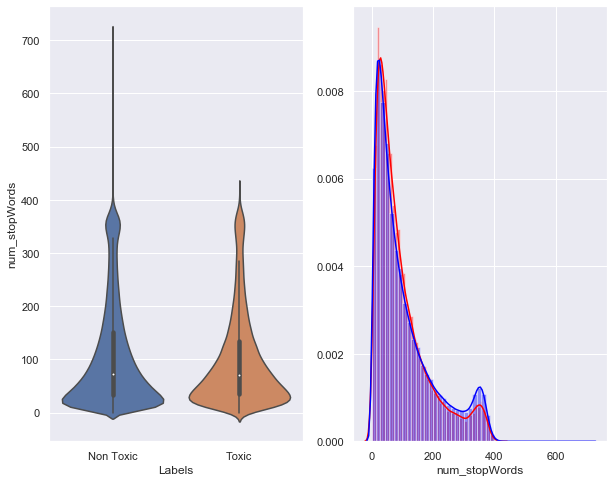

In [46]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'Labels', y = 'num_stopWords', data = train[0:] , )

plt.subplot(1,2,2)
sns.distplot(train[train['Labels'] == "Toxic"]['num_stopWords'][0:] , label = "Toxic", color = 'red')
sns.distplot(train[train['Labels'] == "Non Toxic"]['num_stopWords'][0:] , label = "Non Toxic" , color = 'blue' )
plt.show()

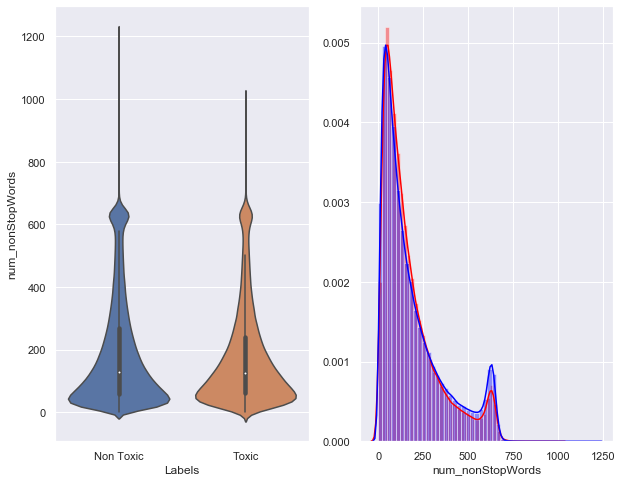

In [47]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'Labels', y = 'num_nonStopWords', data = train[0:] , )

plt.subplot(1,2,2)
sns.distplot(train[train['Labels'] == "Toxic"]['num_nonStopWords'][0:] , label = "Toxic", color = 'red')
sns.distplot(train[train['Labels'] == "Non Toxic"]['num_nonStopWords'][0:] , label = "Non Toxic" , color = 'blue' )
plt.show()

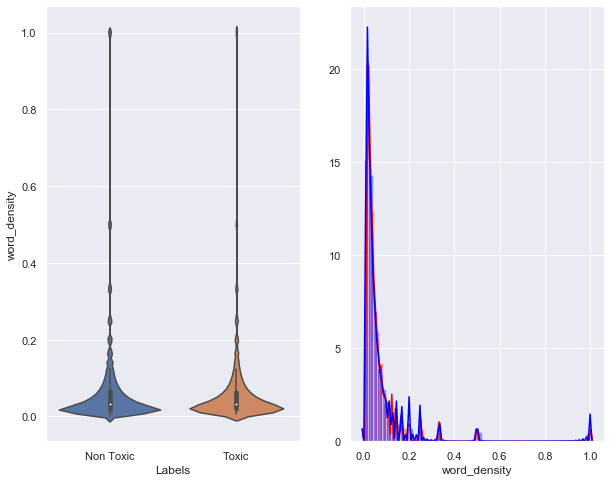

In [48]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'Labels', y = 'word_density', data = train[0:] , )

plt.subplot(1,2,2)
sns.distplot(train[train['Labels'] == "Toxic"]['word_density'][0:] , label = "Toxic", color = 'red')
sns.distplot(train[train['Labels'] == "Non Toxic"]['word_density'][0:] , label = "Non Toxic" , color = 'blue' )
plt.show()

### Here we can observe some of the non ovelapping parts between Toxic and non toxic classes

## Plotting Word cloud for Toxic and Non-Toxic comments 

In [49]:
Data_EDA_Toxic=Data_EDA[Data_EDA["Labels"]=="Toxic"]

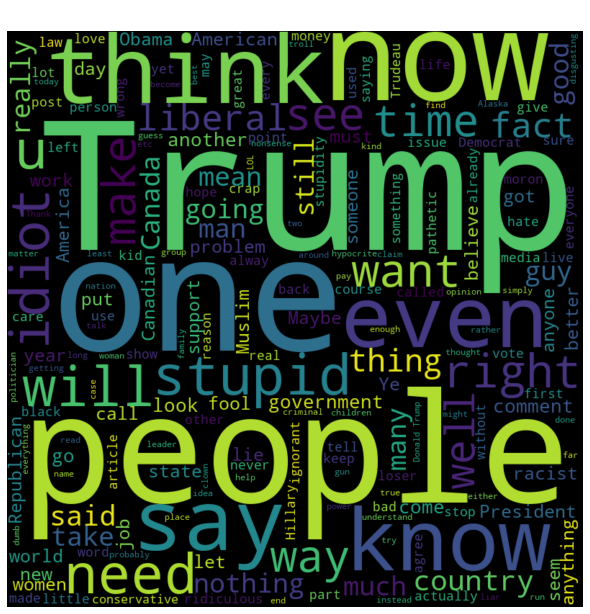

In [50]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(' '.join(list(Data_EDA_Toxic["comment_text"]))) 
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.imshow(wordcloud,interpolation='bilinear')
plt.title("Toxic WordCloud", fontsize=25,color='w')  
plt.show()   



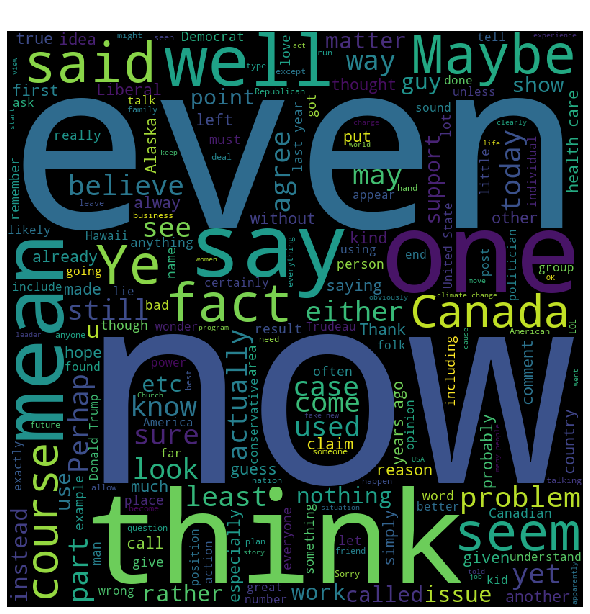

In [124]:
Data_EDA_Non_Toxic=Data_EDA[Data_EDA["Labels"]=="Non Toxic"]

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(' '.join(list(Data_EDA_Non_Toxic["comment_text"]))) 
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Non Toxic WordCloud", fontsize=25,color='w')  
plt.show()   

## Summary of EDA analysis
1. Number of Toxic comments is less than Non Toxic comments i.e. 8 percent of toxic 92 percent of non toxic. 

2. We printed the percentile values of length of comments and observed 90th percentile value is 652 for Toxic and 90th percentile value is 755 for non Toxic.We also chcked there are 7 comments woth length more than 1300 and all are non toxic.

3. We created some text features and plotted the correlation table with Target and Identities Features. We also plotted the correlation table between extracted features Vs extracted features, to check correlation among them. 

4. We applied some feature selection methods and used the results of Embedded Method where out of 16 we selected 11 as relevent features.

5. We plotted Vilion and Density plot for some of the extracted features with target labels.

6. We plotted Word cloud for Toxic and Non-Toxic comments. 


## Calculate the final score

## Evaluation Metric:

Our goal to to reduce unintented bias as much as possible so we will use a special matric. 

we are refering the following information from <a href="https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview/evaluation" target="_blank"><b>here</b></a>.

We will use metric that combines several submetrics to balance overall performance with various aspects of unintended bias.


<ol>
<li><b>Overall AUC</b><br>
   This is the ROC-AUC for the full evaluation set.</li><br><br>

<li><b>Bias AUCs</b><br>
   Here we calculate the ROC-AUC on three specific subsets of the test set for each identity, each capturing a different      aspect of unintended bias.<br><br>

<ol type="a"><li><b>Subgroup AUC:</b><br> 
       Here, we restrict the data set to only the examples that mention the specific identity subgroup. A low value in this metric means the model does a poor job of distinguishing between toxic and non-toxic comments that mention the identity.</li><br>
<li><b>BPSN (Background Positive, Subgroup Negative) AUC:</b><br> 
       Here, we restrict the test set to the non-toxic examples that mention the identity and the toxic examples that do not. A low value in this metric means that the model confuses non-toxic examples that mention the identity with toxic examples that do not, likely meaning that the model predicts higher toxicity scores than it should for non-toxic examples mentioning the identity.</li><br>

<li><b>BNSP (Background Negative, Subgroup Positive) AUC:</b><br>
       Here, we restrict the test set to the toxic examples that mention the identity and the non-toxic examples that do not. A low value here means that the model confuses toxic examples that mention the identity with non-toxic examples that do not, likely meaning that the model predicts lower toxicity scores than it should for toxic examples mentioning the identity.</li>
</li><br><br>


In [88]:
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)


## Generalized Mean of Bias AUCs

To combine the per-identity Bias AUCs into one overall measure, we calculate their generalized mean as defined below:

$$M_p(m_s) = \left(\frac{1}{N} \sum_{s=1}^{N} m_s^p\right)^\frac{1}{p}$$


where: 

$$  M_p = the \ pth\ power\ mean\ function$$
$$m_s = the\ bias\ metric\ m \ calulated \ for \ subgroup$$
$$N = number \ of \ identity \ subgroups$$

## Final Metric

$$score = w_0 AUC_{overall} + \sum_{a=1}^{A} w_a M_p(m_{s,a})$$

where:

$$A = number \ of \ submetrics \ (3)$$

$$m_{s,a} = bias \ metric \ for \ identity \ subgroup \ s \ using \ submetric \ a$$

$$w_a = a \ weighting \ for \ the \ relative \ importance \ of \ each \ submetric; \ all \ four \ w \ values \ set \ to \ 0.25$$

In [89]:
def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)
    
#get_final_metric(bias_metrics_df, calculate_overall_auc(X_test_TFIDF, MODEL_NAME))

## 2. Data Pre-processing and vectorizing:

## a. We Preprocess and Vectorize for TFIDF

### Loading and Splitting the data in Train and Test

In [90]:
train_TFIDF = train.copy()#pd.read_csv('../input/train.csv')
#submission_TFIDF = pd.read_csv('../input/test.csv')

In [91]:
submission_TFIDF.columns

Index(['id', 'comment_text', 'total_length', 'capitals', 'caps_vs_length',
       'num_exclamation_marks', 'num_question_marks', 'num_punctuation',
       'num_symbols', 'num_words', 'num_unique_words', 'words_vs_unique',
       'num_smilies', 'word_density', 'num_stopWords', 'num_nonStopWords',
       'num_nonStopWords_density', 'num_stopWords_density'],
      dtype='object')

In [92]:
train_TFIDF.columns

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count', 'Labels',
       'total_length', 'capitals', 'num_exclamation_marks',
       'num_question_marks', 'num_punctuation', 'num_symbols', 'num_words',
       'num_unique_words', 'word_density', 'num_stopWords',
       'num_nonStopWords'],
  

In [93]:
submission_TFIDF.head()

,id,comment_text,total_length,capitals,caps_vs_length,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,num_words,num_unique_words,words_vs_unique,num_smilies,word_density,num_stopWords,num_nonStopWords,num_nonStopWords_density,num_stopWords_density
0,7097320,integrity mean pay debt . apply president tru...,84,4,0.047619,0,1,1,0,15,15,1.000000,0,0.066667,36,48,0.571429,0.428571
1,7097321,malfeasance administrator board . wasting money !,84,4,0.047619,1,0,1,0,14,13,0.928571,0,0.076923,36,48,0.571429,0.428571
2,7097322,@ rmiller - spoken like true elitist . look bu...,198,8,0.040404,0,0,5,1,35,31,0.885714,0,0.032258,59,139,0.702020,0.297980
3,7097323,"paul : thank kind word . , indeed , strong bel...",993,31,0.031219,0,0,37,0,162,114,0.703704,0,0.009804,358,635,0.639476,0.360524
4,7097324,sorry missed high school . eisenhower sent tro...,345,18,0.052174,0,0,3,2,65,51,0.784615,0,0.020000,122,223,0.646377,0.353623


In [94]:
train_TFIDF['comment_text'] = train_TFIDF['comment_text'].astype(str) 
submission_TFIDF['comment_text'] = submission_TFIDF['comment_text'].astype(str) 
# List all identities
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

TOXICITY_COLUMN = 'target' 

# Convert taget and identity columns to booleans
def convert_to_bool(df, col_name):
    df[col_name] = np.where(df[col_name] >= 0.5, True, False)
    
def convert_dataframe_to_bool(df):
    bool_df = df.copy()
    for col in ['target'] + identity_columns:
        convert_to_bool(bool_df, col)
    return bool_df

train_TFIDF = convert_dataframe_to_bool(train_TFIDF)    

In [95]:
train_TFIDF.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,capitals,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,num_words,num_unique_words,word_density,num_stopWords,num_nonStopWords
0,59848,False,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,3,1,2,3,0,19,19,0.052632,38,63
1,59849,False,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,3,3,0,2,0,22,22,0.045455,41,73
2,59852,False,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2,1,0,2,0,16,16,0.062500,32,54
3,59855,False,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,3,0,2,0,0,17,16,0.062500,30,54
4,59856,True,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,0,0,0,1,0,8,8,0.125000,12,24


In [96]:
train_TFIDF_label=train_TFIDF["target"].copy()

In [97]:
train_TFIDF.drop(columns="target",inplace=True)

In [98]:
#train_TFIDF = pd.read_csv('./input/train.csv')

X_train_cv_TFIDF, X_test_TFIDF, y_train_cv_TFIDF, y_test_TFIDF = train_test_split(train_TFIDF,train_TFIDF_label, test_size = 0.2, random_state = 0)
#X_train_TFIDF, X_test_TFIDF, y_cv_TFIDF, y_cv_TFIDF = train_test_split(X_train_cv_TFIDF,y_train_cv_TFIDF, test_size = 0.2, random_state = 0)
X_train_cv_TFIDF.reset_index(inplace=True)
X_test_TFIDF.reset_index(inplace=True)

In [99]:
numerical_cols=['total_length', 'capitals', 'num_exclamation_marks','num_question_marks', 'num_punctuation', 'num_words', 'num_unique_words',\
         'num_symbols','word_density','num_stopWords','num_nonStopWords']

In [100]:
from sklearn.preprocessing import StandardScaler
numerical_feature_train = StandardScaler().fit_transform(X_train_cv_TFIDF[numerical_cols])
numerical_feature_test = StandardScaler().transform(X_test_TFIDF[numerical_cols])
numerical_submission_TFIDF = StandardScaler().transform(submission_TFIDF[numerical_cols])

In [101]:
numerical_feature_train.shape

(1443899, 11)

In [102]:
numerical_feature_test.shape

(360975, 11)

In [103]:
numerical_submission_TFIDF.shape

(97320, 11)

In [104]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
import nltk
import re 

nltk.download('wordnet')
stop_words = set(stopwords.words('english')) 
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Anurag\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [105]:
def preprocessingText(text):
    
    words=word_tokenize(text)
    
    wordsWihoutStopwords=[lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words]
    
    text=" ".join(wordsWihoutStopwords)
    
    text=re.sub(r"[^A-Za-z\?\@\^\$\%\`\'\#\:\-\)\(\)\;\.\,\&\!]"," ",text)
    text=re.sub(r"\s+"," ",text)
    
    return text

In [106]:
import nltk
nltk.download('punkt')

X_train_cv_TFIDF["comment_text"]=X_train_cv_TFIDF["comment_text"].apply(preprocessingText)
X_test_TFIDF["comment_text"]=X_test_TFIDF["comment_text"].apply(preprocessingText)
submission_TFIDF["comment_text"]=submission_TFIDF["comment_text"].apply(preprocessingText)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Anurag\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\Anurag\Anaconda3\envs\New TensorFlow\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Anurag\Anaconda3\envs\New TensorFlow\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [107]:
X_train_cv_TFIDF["comment_text"][0]

" bad season make forget national championship game appearance , conference championship , double digit win season row ? agree new staff even better , n't mean previous one sucked , ca n't still appreciate helped ."

In [108]:
preprocessingText(X_train_cv_TFIDF["comment_text"][0])

"bad season make forget national championship game appearance , conference championship , double digit win season row ? agree new staff even better , n't mean previous one sucked , ca n't still appreciate helped ."

##  Vectoring Text with TfIdf Vectorizer

In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000,ngram_range=(1,2))
X_tfidf_train = vectorizer.fit_transform(X_train_cv_TFIDF["comment_text"])

print(vectorizer.get_feature_names()[:25])

['aa', 'ab', 'abandon', 'abandoned', 'abc', 'abide', 'abiding', 'abiding citizen', 'ability', 'able', 'able afford', 'able get', 'abolish', 'aboriginal', 'abortion', 'about', 'abraham', 'abroad', 'absence', 'absent', 'absolute', 'absolutely', 'absolutely correct', 'absolutely nothing', 'absolutely right']


In [110]:
scores = zip(vectorizer.get_feature_names(),\
                 np.asarray(X_tfidf_train.sum(axis=0)).ravel())
    
sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)

In [111]:
sorted_scores[-10:]

[('statehood', 96.13453957650017),
 ('equitable', 95.53603627250224),
 ('carbon dioxide', 95.38907733522201),
 ('kwh', 92.85909006146649),
 ('let look', 92.1671458315571),
 ('lastly', 90.79061404087636),
 ('dnr', 88.96467417611906),
 ('ly', 86.23879839823303),
 ('massengill', 85.88180720682678),
 ('hugh massengill', 84.18896199832966)]

In [112]:
lowTfidfWords=[]
for key,value in dict(sorted_scores).items():
    if value<=150:
        lowTfidfWords.append(key)


In [113]:
len(set(lowTfidfWords))

2113

## Removing all words with TfIdf score less than 150 

In [114]:
def preProcessingBasedOnTfidfScore(text):
    
    words=word_tokenize(text)
    
    wordsWihoutStopwords=[word for word in words if word.lower() not in lowTfidfWords]
    
    text=" ".join(wordsWihoutStopwords)
   
    return text

In [115]:
X_train_cv_TFIDF["comment_text"]=X_train_cv_TFIDF["comment_text"].apply(preProcessingBasedOnTfidfScore)

C:\Users\Anurag\Anaconda3\envs\New TensorFlow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [116]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000,ngram_range=(1,2))
X_tfidf_train = vectorizer.fit_transform(X_train_cv_TFIDF["comment_text"])
X_tfidf_test = vectorizer.transform(X_test_TFIDF["comment_text"])
submission_test_tfidf=vectorizer.transform(submission_TFIDF["comment_text"])

print("Shape of Train data: {}".format(X_tfidf_train.shape))
print("Shape of Test data: {}".format(X_tfidf_test.shape))      
print("Shape of Test data: {}".format(submission_test_tfidf.shape))   

Shape of Train data: (1443899, 10000)
Shape of Test data: (360975, 10000)
Shape of Test data: (97320, 10000)


In [117]:
from scipy.sparse import hstack

X_train = hstack((X_tfidf_train,numerical_feature_train))
X_test = hstack((X_tfidf_test,numerical_feature_test))
X_submission = hstack((submission_test_tfidf,numerical_submission_TFIDF))

In [118]:
X_train.shape

(1443899, 10011)

In [119]:
X_test.shape

(360975, 10011)

In [120]:
numerical_submission_TFIDF.shape

(97320, 11)

In [121]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn import linear_model

In [122]:
y_train_cv_TFIDF

1072905    False
659482     False
289250      True
497151     False
1757082    False
           ...  
152315     False
963395     False
117952     False
1484405    False
305711     False
Name: target, Length: 1443899, dtype: bool

In [123]:
X_train.shape

(1443899, 10011)

## Logistic Regression

In [91]:
parameters = {'alpha': [0.01,0.1,10,1000,10**-14, 10**-12, 10**-10, 10**-8, 10**-6, 10**-4, 10**-2, 10**0, 10**2, 10**4, 10**6]}
log_reg = linear_model.SGDClassifier(loss="log",n_jobs=-1,class_weight='balanced')
grid_search = GridSearchCV(log_reg, parameters,cv=4)
grid_search.fit(X_train, y_train_cv_TFIDF)

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight='balanced',
                                     early_stopping=False, epsilon=0.1,
                                     eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='log', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=-1,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.01, 0.1, 10, 1000, 1e-14, 1e-12, 1e-10,
                                   1e-08, 1e-06, 0.0001, 0.01, 1, 100, 10000,
     

In [92]:
grid_search.best_estimator_

SGDClassifier(alpha=1000000, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [93]:
log_reg=grid_search.best_estimator_
log_reg.fit(X_train, y_train_cv_TFIDF)
sig_clf = CalibratedClassifierCV(log_reg, method="sigmoid")
sig_clf.fit(X_train, y_train_cv_TFIDF)


C:\Users\Anurag\Anaconda3\envs\New TensorFlow\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=1000000,
                                                    average=False,
                                                    class_weight='balanced',
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='log', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=-1, penalty='l2',
                                                    power_t=0.5,
                                                    random_state=None,
                                                    shuffle=

In [94]:
predict_y = sig_clf.predict_proba(X_test)

In [95]:
MODEL_NAME = 'tfidf_Log_reg'
X_test_TFIDF[MODEL_NAME] = list(predict_y[:,1])

C:\Users\Anurag\Anaconda3\envs\New TensorFlow\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [96]:
X_test_TFIDF.head()

,index,id,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,num_words,num_unique_words,word_density,num_stopWords,num_nonStopWords,tfidf_Log_reg
0,546354,911573,hour student learning time classroom time stu...,0.0,0.0,0.0,0.000000,0.0,NaN,NaN,...,0,0,7,0,65,55,0.018519,138,245,0.074991
1,412488,748010,think author absolutely correct say two-state ...,0.0,0.0,0.0,0.000000,0.0,NaN,NaN,...,0,0,3,0,58,51,0.019608,121,203,0.077387
2,796018,5094769,know qur'an written waaay back saudi arabia do...,0.0,0.0,0.0,0.000000,0.0,NaN,NaN,...,0,0,7,0,63,54,0.019231,131,186,0.076881
3,922266,5247850,jt 's sun starting set shallowness becoming ev...,0.0,0.0,0.0,0.166667,0.0,NaN,NaN,...,0,0,1,0,14,12,0.083333,33,41,0.087477
4,1711194,6220033,"elite , democrat republican , tried grease tru...",0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0,0,3,0,12,11,0.090909,26,53,0.087364


In [97]:
# List all identities
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']
TOXICITY_COLUMN = 'target'

In [98]:
X_test_TFIDF['target']=list(y_test_TFIDF)

C:\Users\Anurag\Anaconda3\envs\New TensorFlow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [99]:
bias_metrics_df = compute_bias_metrics_for_model(X_test_TFIDF, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
bias_metrics_df

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
0,male,8933,0.562800,0.680150,0.415546
1,female,10688,0.570522,0.712102,0.393433
3,christian,8099,0.601096,0.747598,0.371283
5,muslim,4224,0.601714,0.719508,0.410905
7,white,4989,0.607716,0.712912,0.428360
4,jewish,1517,0.624993,0.765010,0.395446
6,black,3057,0.635557,0.758260,0.409530
2,homosexual_gay_or_lesbian,2187,0.648752,0.753157,0.418705
8,psychiatric_or_mental_illness,999,0.687547,0.714371,0.496897


In [100]:
Log_re_model=get_final_metric(bias_metrics_df, calculate_overall_auc(X_test_TFIDF, MODEL_NAME))
Log_re_model

0.5702171242085619

## Submission for Logistic Regression

In [101]:
submission = pd.DataFrame.from_dict({
    'id': submission_TFIDF['id'],
    'prediction': list(sig_clf.predict_proba(X_submission)[:,1])
}) 

In [102]:
submission.head()

,id,prediction
0,7097320,0.088040
1,7097321,0.092520
2,7097322,0.081529
3,7097323,0.053617
4,7097324,0.074699


In [103]:
submission.to_csv("Log_lr_submission.csv",index=False)

## Kaggle Score for Logistic regression Submission:

<img src="https://i.ibb.co/Y3LRxBf/log-Reg-Kaggle-Score.png" alt="log-Reg-Kaggle-Score" border="0" />

## SVM

In [104]:
parameters = {'alpha': [0.01,0.1,10,1000,10**-14, 10**-12, 10**-10, 10**-8, 10**-6, 10**-4, 10**-2, 10**0, 10**2, 10**4, 10**6]}
svm = linear_model.SGDClassifier(loss="hinge",n_jobs=-1,class_weight='balanced')
grid_search = GridSearchCV(svm, parameters,cv=4)
grid_search.fit(X_train, y_train_cv_TFIDF)

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight='balanced',
                                     early_stopping=False, epsilon=0.1,
                                     eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=-1,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.01, 0.1, 10, 1000, 1e-14, 1e-12, 1e-10,
                                   1e-08, 1e-06, 0.0001, 0.01, 1, 100, 10000,
   

In [105]:
grid_search.best_estimator_

SGDClassifier(alpha=1000000, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [106]:
svm_best=grid_search.best_estimator_
svm_best.fit(X_train, y_train_cv_TFIDF)
sig_clf = CalibratedClassifierCV(svm_best, method="sigmoid")
sig_clf.fit(X_train, y_train_cv_TFIDF)

C:\Users\Anurag\Anaconda3\envs\New TensorFlow\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=1000000,
                                                    average=False,
                                                    class_weight='balanced',
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='hinge', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=-1, penalty='l2',
                                                    power_t=0.5,
                                                    random_state=None,
                                                    shuffl

In [107]:
predict_y = sig_clf.predict_proba(X_test)
MODEL_NAME = 'tfidf_SVM'
X_test_TFIDF[MODEL_NAME] = list(predict_y[:,1])

C:\Users\Anurag\Anaconda3\envs\New TensorFlow\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [108]:
bias_metrics_df = compute_bias_metrics_for_model(X_test_TFIDF, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
bias_metrics_df

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
0,male,8933,0.562800,0.680150,0.415546
1,female,10688,0.570521,0.712102,0.393432
3,christian,8099,0.601096,0.747598,0.371283
5,muslim,4224,0.601714,0.719508,0.410905
7,white,4989,0.607717,0.712912,0.428359
4,jewish,1517,0.624990,0.765010,0.395446
6,black,3057,0.635557,0.758260,0.409530
2,homosexual_gay_or_lesbian,2187,0.648752,0.753157,0.418706
8,psychiatric_or_mental_illness,999,0.687547,0.714370,0.496897


In [109]:
get_final_metric(bias_metrics_df, calculate_overall_auc(X_test_TFIDF, MODEL_NAME))

0.5702170289286435

In [110]:
submission = pd.DataFrame.from_dict({
    'id': submission_TFIDF['id'],
    'prediction': list(sig_clf.predict_proba(X_submission)[:,1])
}) 

submission.to_csv("SVM_submission.csv",index=False)

## Kaggle Score for SVM Submission:

<img src="https://i.ibb.co/GT7BRz4/SVMKaggle-Score.png" alt="SVMKaggle-Score" border="0">

## Decision Tree Classifier:

In [111]:
prams={
 
     'max_depth':[3,5,10],
    'min_samples_split':[5,10,100,500],
    
}

In [112]:
dt=DecisionTreeClassifier(criterion='gini',class_weight = 'balanced')
random_clf = RandomizedSearchCV(dt, param_distributions=prams,cv=5,random_state=25,n_jobs=-1)
random_clf.fit(X_train, y_train_cv_TFIDF)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=None,
                                                    splitter='

In [113]:
random_clf.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [114]:
dt_best=random_clf.best_estimator_
dt_best.fit(X_train, y_train_cv_TFIDF)
sig_clf = CalibratedClassifierCV(dt_best, method="sigmoid")
sig_clf.fit(X_train, y_train_cv_TFIDF)

C:\Users\Anurag\Anaconda3\envs\New TensorFlow\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


CalibratedClassifierCV(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=3,
                                                             max_features=None,
                                                             max_leaf_nodes=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=1,
                                                             min_samples_split=10,
                                                             min_weight_fraction_leaf=0.0,
                                                             presort=False,
                                                             random_state=None,
              

In [115]:
predict_y = sig_clf.predict_proba(X_test)
MODEL_NAME = 'tfidf_dt'
X_test_TFIDF[MODEL_NAME] = list(predict_y[:,1])

C:\Users\Anurag\Anaconda3\envs\New TensorFlow\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [116]:
bias_metrics_df = compute_bias_metrics_for_model(X_test_TFIDF, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
bias_metrics_df

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
2,homosexual_gay_or_lesbian,2187,0.515251,0.584472,0.517908
5,muslim,4224,0.527755,0.585678,0.529470
6,black,3057,0.536366,0.583387,0.540412
8,psychiatric_or_mental_illness,999,0.537187,0.582957,0.540259
4,jewish,1517,0.539271,0.585455,0.539684
7,white,4989,0.539683,0.584059,0.543629
1,female,10688,0.552732,0.585765,0.554212
0,male,8933,0.553452,0.584907,0.555655
3,christian,8099,0.553541,0.585425,0.554427


In [117]:
get_final_metric(bias_metrics_df, calculate_overall_auc(X_test_TFIDF, MODEL_NAME))

0.5624180208275404

In [118]:
submission = pd.DataFrame.from_dict({
    'id': submission_TFIDF['id'],
    'prediction': list(sig_clf.predict_proba(X_submission)[:,1])
}) 

submission.to_csv("DT_submission.csv",index=False)

## Decision Tree Submission result

<img src="https://i.ibb.co/VpK6fKX/DT.png" alt="DT" border="0">



## Random Forrest

In [119]:
prams={
 
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'min_samples_split':[5,10,100,500],
    
}

In [120]:
rf=RandomForestClassifier(class_weight = 'balanced')
random_clf = RandomizedSearchCV(rf, param_distributions=prams,cv=5,random_state=25,n_jobs=-1)
random_clf.fit(X_train, y_train_cv_TFIDF)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_job

In [121]:
random_clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [122]:
rf_best=random_clf.best_estimator_
rf_best.fit(X_train, y_train_cv_TFIDF)
sig_clf = CalibratedClassifierCV(rf_best, method="sigmoid")
sig_clf.fit(X_train, y_train_cv_TFIDF)

C:\Users\Anurag\Anaconda3\envs\New TensorFlow\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=10,
                                                             max_features='auto',
                                                             max_leaf_nodes=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=1,
                                                             min_samples_split=5,
                                                             min_weight_fraction_leaf=0.0,
                                                             n_estimators=200,
            

In [123]:
predict_y = sig_clf.predict_proba(X_test)
MODEL_NAME = 'tfidf_rf'
X_test_TFIDF[MODEL_NAME] = list(predict_y[:,1])

C:\Users\Anurag\Anaconda3\envs\New TensorFlow\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [124]:
bias_metrics_df = compute_bias_metrics_for_model(X_test_TFIDF, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
bias_metrics_df

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
2,homosexual_gay_or_lesbian,2187,0.715656,0.676879,0.905565
6,black,3057,0.721474,0.529977,0.961982
7,white,4989,0.750193,0.472295,0.978220
5,muslim,4224,0.762134,0.680785,0.930530
4,jewish,1517,0.817324,0.810925,0.878265
1,female,10688,0.818303,0.784398,0.905414
0,male,8933,0.833470,0.753316,0.929797
3,christian,8099,0.848744,0.867818,0.859397
8,psychiatric_or_mental_illness,999,0.857090,0.847156,0.893607


In [125]:
get_final_metric(bias_metrics_df, calculate_overall_auc(X_test_TFIDF, MODEL_NAME))

0.7991853043618373

In [126]:
submission = pd.DataFrame.from_dict({
    'id': submission_TFIDF['id'],
    'prediction': list(sig_clf.predict_proba(X_submission)[:,1])
}) 

submission.to_csv("RF_submission.csv",index=False)

## RF Submission Results
<img src="https://i.ibb.co/KhxcnDy/RF.png" alt="RF" border="0">

## XGB

In [125]:
prams={
 
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'min_samples_split':[5,10,100,500],
    
}

In [89]:
xgb=XGBClassifier(class_weight = 'balanced')
random_clf = RandomizedSearchCV(xgb, param_distributions=prams,cv=5,random_state=25,n_jobs=-1)
random_clf.fit(X_train, y_train_cv_TFIDF)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           class_weight='balanced',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,

In [90]:
random_clf.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, min_samples_split=10, missing=None,
              n_estimators=2000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [126]:
xgb_best=XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, min_samples_split=10, missing=None,
              n_estimators=2000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [136]:
#xgb_best=random_clf.best_estimator_
xgb_best.fit(X_train, y_train_cv_TFIDF)

In [128]:
sig_clf = CalibratedClassifierCV(xgb_best, method="sigmoid")
sig_clf.fit(X_train, y_train_cv_TFIDF)

C:\Users\Anurag\Anaconda3\envs\New TensorFlow\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                    booster='gbtree',
                                                    class_weight='balanced',
                                                    colsample_bylevel=1,
                                                    colsample_bynode=1,
                                                    colsample_bytree=1, gamma=0,
                                                    learning_rate=0.1,
                                                    max_delta_step=0,
                                                    max_depth=5,
                                                    min_child_weight=1,
                                                    min_samples_split=10,
                                                    missing=None,
                                                    n_estimators=2000, n_jobs=1,
                                                    nthread=

In [129]:
predict_y = sig_clf.predict_proba(X_test)
MODEL_NAME = 'tfidf_xgb'
X_test_TFIDF[MODEL_NAME] = list(predict_y[:,1])

C:\Users\Anurag\Anaconda3\envs\New TensorFlow\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [137]:
X_test_TFIDF['target']=list(y_test_TFIDF)

C:\Users\Anurag\Anaconda3\envs\New TensorFlow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [138]:
X_test_TFIDF.columns

Index(['index', 'id', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count', 'Labels',
       'total_length', 'capitals', 'num_exclamation_marks',
       'num_question_marks', 'num_punctuation', 'num_symbols', 'num_words',
       'num_unique_words', 'word_density', 'num_stopWords', 'num_nonStopWords',
       'tfi

In [134]:
X_test_TFIDF.to_csv("X_test_TFIDF_XGB.csv")

In [139]:
bias_metrics_df = compute_bias_metrics_for_model(X_test_TFIDF, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
bias_metrics_df

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
2,homosexual_gay_or_lesbian,2187,0.796001,0.744686,0.966052
6,black,3057,0.809326,0.739195,0.968786
7,white,4989,0.828829,0.739986,0.972733
5,muslim,4224,0.831011,0.777763,0.965736
4,jewish,1517,0.859989,0.858554,0.943875
1,female,10688,0.882565,0.869198,0.946894
0,male,8933,0.890700,0.861520,0.954277
3,christian,8099,0.897862,0.914826,0.921609
8,psychiatric_or_mental_illness,999,0.905006,0.840734,0.968843


In [140]:
bias_metrics_df = compute_bias_metrics_for_model(X_test_TFIDF, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
bias_metrics_df

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
2,homosexual_gay_or_lesbian,2187,0.796001,0.744686,0.966052
6,black,3057,0.809326,0.739195,0.968786
7,white,4989,0.828829,0.739986,0.972733
5,muslim,4224,0.831011,0.777763,0.965736
4,jewish,1517,0.859989,0.858554,0.943875
1,female,10688,0.882565,0.869198,0.946894
0,male,8933,0.890700,0.861520,0.954277
3,christian,8099,0.897862,0.914826,0.921609
8,psychiatric_or_mental_illness,999,0.905006,0.840734,0.968843


In [141]:
get_final_metric(bias_metrics_df, calculate_overall_auc(X_test_TFIDF, MODEL_NAME))

0.8853402995852235

In [142]:
submission = pd.DataFrame.from_dict({
    'id': submission_TFIDF['id'],
    'prediction': list(sig_clf.predict_proba(X_submission)[:,1])
}) 

submission.to_csv("XGB_submission.csv",index=False)

## XGB Submission Results

<img src="https://i.ibb.co/Zx5pFw5/XGB.png" alt="XGB" border="0">

# So, XGB Performs the best among the classical models with Test Score: 0.88534 and Kaggle submission Score: 0.88400